In [1]:
import glob
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import pickle
import astropy.units as u
import astropy.constants as const

from transitleastsquares import transitleastsquares

In [2]:
df = pd.read_csv("../data/catalogues/rev_AF_stars.csv", dtype={'kic': str})
candidates = pd.read_csv("candidates.csv", dtype={'kic': str}, delimiter='\t')
df = df.merge(candidates, left_on='kic', right_on='kic')

In [3]:
df

,kic,source_id,sdss_g,parallax,parallax_error,Ag_Green_2017,Ag_Green_2017_sigma,Teffi,e_Teffi,FeHi,...,new_mass,new_mass_std,mass_qflag,loglbol_g_median,loglbol_sigp,loglbol_sigm,dSct,period,t0,bls_depth
0,2837174,2099526597228830336,11.835,1.111,0.024,0.30,0.05,7385,258,0.05,...,1.68,0.25,0,1.177,0.027,0.027,1,33.381229,129.456313,0.060600
1,4380834,2076217259966879488,14.172,0.731,0.023,0.54,0.05,7613,80,0.08,...,1.44,0.25,5,0.723,0.038,0.038,1,0.889871,-729.138777,0.200316
2,5724523,2076780141199369472,13.577,0.501,0.015,1.00,0.11,7350,257,-0.18,...,1.91,0.25,0,1.470,0.052,0.051,1,0.545737,-735.105918,0.016599
3,7302192,2078701812643727744,14.772,0.378,0.029,0.86,0.03,6601,231,-0.27,...,1.62,0.25,0,1.256,0.072,0.067,1,74.692581,-75.788361,1.432771
4,7621793,2078027846375023872,14.383,0.602,0.019,0.57,0.02,6789,237,0.06,...,1.41,0.25,0,0.854,0.033,0.033,1,11.880412,138.550779,0.429600
5,7767699,2078789734909398144,11.836,1.109,0.023,0.45,0.07,8230,288,-0.02,...,1.75,0.25,0,1.206,0.032,0.032,1,1.128280,-734.116164,0.008033
6,7975162,2078812863320308736,12.643,0.739,0.025,0.58,0.04,7082,219,-0.21,...,1.83,0.25,0,1.369,0.037,0.037,1,37.829557,127.479715,1.044000
7,8057661,2076042403255932544,11.520,0.310,0.046,1.41,0.10,8453,295,-0.10,...,0.00,0.25,6,2.895,0.154,0.135,1,24.422897,133.503250,0.156800
8,8249829,2078915976894229888,14.487,0.478,0.019,0.76,0.04,7109,248,-0.11,...,1.58,0.25,0,1.078,0.042,0.041,1,1.012885,-58.896685,0.161843
9,8456151,2079118179651367040,11.633,1.704,0.075,0.57,0.18,6531,228,-0.92,...,1.50,0.25,0,1.086,0.076,0.076,1,28.287995,121.275677,0.496600


In [5]:
import tqdm

durs = []
for index, row in df.iterrows():
    f = glob.glob(f"../prewhitening/results/spline and BIC/prewhitened/*{row.kic}*")[0]
    time, flux, flux_err = np.loadtxt(f, unpack=True)
    lc = lk.LightCurve(time, flux + 1., flux_err)
    lc = lc.flatten(window_length=201, break_tolerance=11).remove_outliers(sigma_upper=5, sigma_lower=5)
    time, flux, flux_err = lc.time.value, lc.flux.value, lc.flux_err.value
    flux -= 1.

    m = np.ones_like(time, dtype=bool)
    ref_time = 0.5 * (np.min(time) + np.max(time))
    x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
    y = np.ascontiguousarray(flux[m], dtype=np.float64)

    model = transitleastsquares(time, flux / 1e3 + 1)
    if row.period < 1.:
        min_p = 1e-5
    else:
        min_p = row.period - 1.
    results = model.power(period_min=min_p, period_max=row.period+1, oversampling_factor=1, use_threads=1, n_transits_min=1)
    
    durs.append(results.duration)

/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)
  0%|          | 0/362 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 29 durations
Searching 65094 data points, 362 periods from 32.382 to 34.376 days
Using 1 of 4 CPU threads


100%|██████████| 362/362 periods | 00:36<00:00
  0%|          | 1/8167 [00:00<15:16,  8.91it/s]

Searching for best T0 for period 33.38390 days


100%|██████████| 8167/8167 [00:16<00:00, 502.63it/s]
/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)
  0%|          | 3/21756 periods | 00:00<17:53

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 24 durations
Searching 51510 data points, 21756 periods from 0.602 to 1.89 days
Using 1 of 4 CPU threads


100%|██████████| 21756/21756 periods | 21:01<00:00
/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(
/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)
  0%|          | 3/18651 periods | 00:00<10:43

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 23 durations
Searching 64890 data points, 18651 periods from 0.602 to 1.546 days
Using 1 of 4 CPU threads


 13%|█▎        | 2473/18651 periods | 01:26<08:28

KeyboardInterrupt: 

 13%|█▎        | 2474/18651 periods | 01:37<08:28

In [5]:
row.period

0.8898710435

/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


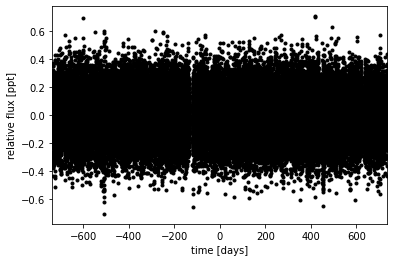

In [10]:
ii = 0
row = df.iloc[ii]
f = glob.glob(f"../prewhitening/results/spline and BIC/prewhitened/*{row.kic}*")[0]
time, flux, flux_err = np.loadtxt(f, unpack=True)
lc = lk.LightCurve(time, flux + 1., flux_err)
lc = lc.flatten(window_length=201, break_tolerance=11).remove_outliers(sigma_upper=5, sigma_lower=5)
time, flux, flux_err = lc.time.value, lc.flux.value, lc.flux_err.value
flux -= 1.

m = np.ones_like(time, dtype=bool)
ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
y = np.ascontiguousarray(flux[m], dtype=np.float64)
#
plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

In [11]:
row.period

33.38122912

/home/daniel/anaconda3/envs/exoplanet_test/lib/python3.8/site-packages/transitleastsquares/transit.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lc_arr = numpy.array(lc_arr)
  0%|          | 0/362 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 29 durations
Searching 65094 data points, 362 periods from 32.385 to 34.379 days
Using 2 of 4 CPU threads


100%|██████████| 362/362 periods | 00:21<00:00
  1%|          | 49/8167 [00:00<00:16, 488.89it/s]

Searching for best T0 for period 33.38123 days


100%|██████████| 8167/8167 [00:15<00:00, 529.89it/s]


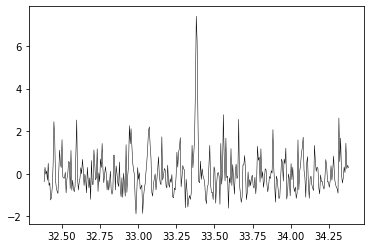

In [12]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(time, flux / 1e3 + 1)
results = model.power(period_min=row.period-1., period_max=row.period+1, oversampling_factor=1, use_threads=2)

plt.plot(results.periods, results.power, color='black', lw=0.5)
# plt.xlim(0, max(results.periods));

In [1]:
(results.duration*u.day).to(u.hr)

NameError: name 'results' is not defined

In [7]:
ii = 0

with open(f'traces/{df.iloc[ii].kic}.pkl', 'rb') as buff:
    data = pickle.load(buff)  

model, trace = data['model'], data['trace']

In [10]:
import arviz as az

with model:
    trace = az.from_pymc3(trace)

In [11]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [12]:
pm.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega,-0.752,1.294,-2.514,2.887,0.373,0.450,9.0,20.0,1.17
ecc,0.246,0.188,0.001,0.597,0.098,0.076,3.0,23.0,1.59
r_pl,0.008,0.003,0.002,0.014,0.001,0.001,5.0,21.0,1.29
b,0.644,0.161,0.372,0.909,0.085,0.069,4.0,38.0,1.52
t0,129.067,0.422,128.360,129.847,0.256,0.205,3.0,19.0,1.94
period,34.822,0.253,34.332,35.116,0.154,0.123,3.0,13.0,1.57
r_star,2.374,0.165,2.078,2.682,0.047,0.034,13.0,59.0,1.12
m_star,1.657,0.203,1.275,2.056,0.031,0.022,42.0,52.0,1.04
u_star[0],0.845,0.253,0.481,1.384,0.131,0.101,4.0,23.0,1.45
u_star[1],-0.159,0.246,-0.618,0.255,0.135,0.107,3.0,18.0,1.63


In [54]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [73]:
row = df.iloc[4]
df

,kic,source_id,sdss_g,parallax,parallax_error,Ag_Green_2017,Ag_Green_2017_sigma,Teffi,e_Teffi,FeHi,...,new_mass,new_mass_std,mass_qflag,loglbol_g_median,loglbol_sigp,loglbol_sigm,dSct,period,t0,bls_depth
0,2837174,2099526597228830336,11.835,1.111,0.024,0.30,0.05,7385,258,0.05,...,1.68,0.25,0,1.177,0.027,0.027,1,33.381229,129.456313,0.060600
1,4380834,2076217259966879488,14.172,0.731,0.023,0.54,0.05,7613,80,0.08,...,1.44,0.25,5,0.723,0.038,0.038,1,0.889871,-729.138777,0.200316
2,5724523,2076780141199369472,13.577,0.501,0.015,1.00,0.11,7350,257,-0.18,...,1.91,0.25,0,1.470,0.052,0.051,1,0.545737,-735.105918,0.016599
3,7302192,2078701812643727744,14.772,0.378,0.029,0.86,0.03,6601,231,-0.27,...,1.62,0.25,0,1.256,0.072,0.067,1,74.692581,-75.788361,1.432771
4,7621793,2078027846375023872,14.383,0.602,0.019,0.57,0.02,6789,237,0.06,...,1.41,0.25,0,0.854,0.033,0.033,1,11.880412,138.550779,0.429600
5,7767699,2078789734909398144,11.836,1.109,0.023,0.45,0.07,8230,288,-0.02,...,1.75,0.25,0,1.206,0.032,0.032,1,1.128280,-734.116164,0.008033
6,7975162,2078812863320308736,12.643,0.739,0.025,0.58,0.04,7082,219,-0.21,...,1.83,0.25,0,1.369,0.037,0.037,1,37.829557,127.479715,1.044000
7,8057661,2076042403255932544,11.520,0.310,0.046,1.41,0.10,8453,295,-0.10,...,0.00,0.25,6,2.895,0.154,0.135,1,24.422897,133.503250,0.156800
8,8249829,2078915976894229888,14.487,0.478,0.019,0.76,0.04,7109,248,-0.11,...,1.58,0.25,0,1.078,0.042,0.041,1,1.012885,-58.896685,0.161843
9,8456151,2079118179651367040,11.633,1.704,0.075,0.57,0.18,6531,228,-0.92,...,1.50,0.25,0,1.086,0.076,0.076,1,28.287995,121.275677,0.496600


In [74]:
import astropy.units as u
import astropy.constants as const

P = (11.88 * u.day).to(u.s)
T = (2.65 * u.hr).to(u.day).to(u.s)

In [75]:
(3 * P) / (np.pi**2 * const.G * T**3)

<Quantity 5383.9478514 kg / m3>

In [76]:
(3*(row.new_mass * u.M_sun).to(u.kg)) / (4*np.pi*(row.new_radius * u.R_sun).to(u.m)**3)

<Quantity 276.50212709 kg / m3>